In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Funções para obtenção dos coeficientes de potência e das potẽncias em si.

In [142]:
def cp_coefficient(rad_s_input: pd.Series, rad_s_data: pd.Series, cp_data: pd.Series) -> pd.Series:
    
    cp = np.interp(x = rad_s_input, xp = rad_s_data, fp = cp_data)
    return cp

def power_propeller_w(cp: float, rev_per_sec: float, propeller_diameter_m: float, rho = 1.225) -> float:
    # Unidades SI

    power = cp * rho * rev_per_sec**3 * propeller_diameter_m**5

    return power

Dados da hélice

In [143]:
prop_diameter = 10 * 0.254 #m

df_prop = pd.read_csv('propeller_data/apcsf_10x4.7_static_kt0835.txt',
            sep = '\s+', dtype = {'RPM': np.float64, 'CT': np.float64, 'CP': np.float64})

df_prop['rad_per_sec'] = df_prop['RPM'] * 2*np.pi/60.0
df_prop['rev_per_sec'] = df_prop['RPM']/60.0
display(df_prop.head())

,RPM,CT,CP,rad_per_sec,rev_per_sec
0,2377.0,0.1059,0.0431,248.918858,39.616667
1,2676.0,0.1079,0.0437,280.230065,44.600000
2,2947.0,0.1079,0.0437,308.609118,49.116667
3,3234.0,0.1104,0.0444,338.663688,53.900000
4,3494.0,0.1117,0.0450,365.890824,58.233333


 Leitura dos joints dos motores. 
 Conforme a documentação, as unidades de velocidade angulas estão em $rad/s$.

 http://docs.ros.org/en/noetic/api/sensor_msgs/html/msg/JointState.html

In [144]:
df_rotor0 = pd.read_csv('logs/Plot_Name-uav1_rotor_0_joint0_velocity.csv', sep = ',',
            names = ['time', 'rad_s'])
df_rotor0.drop([0], axis = 0, inplace = True)
df_rotor0 = df_rotor0.astype({'time': np.float64, 'rad_s': np.float64}, copy = False)

df_rotor1 = pd.read_csv('logs/Plot_Name-uav1_rotor_1_joint0_velocity.csv', sep = ',',
            names = ['time', 'rad_s'])
df_rotor1.drop([0], axis = 0, inplace = True)
df_rotor1 = df_rotor0.astype({'time': np.float64, 'rad_s': np.float64}, copy = False)


df_rotor2 = pd.read_csv('logs/Plot_Name-uav1_rotor_2_joint0_velocity.csv', sep = ',',
            names = ['time', 'rad_s'])
df_rotor2.drop([0], axis = 0, inplace = True)
df_rotor2 = df_rotor0.astype({'time': np.float64, 'rad_s': np.float64}, copy = False)

df_rotor3 = pd.read_csv('logs/Plot_Name-uav1_rotor_3_joint0_velocity.csv', sep = ',',
            names = ['time', 'rad_s'])
df_rotor3.drop([0], axis = 0, inplace = True)
df_rotor3 = df_rotor0.astype({'time': np.float64, 'rad_s': np.float64}, copy = False)

df_list = [df_rotor0, df_rotor1, df_rotor2, df_rotor3]

In [145]:
df_rotor1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10599 entries, 1 to 10599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10599 non-null  float64
 1   rad_s   10599 non-null  float64
dtypes: float64(2)
memory usage: 248.4 KB


In [146]:
def plot_time_vel(df, lab_str):

    time_sec = df.time[::]
    angular_vel = df.rad_s[::]

    plt.plot(time_sec, angular_vel, alpha = 0.8, label = lab_str)
    plt.grid(True)
    plt.xlabel('Time [sec]')
    plt.ylabel('Angular velocity [rad/s]')
    plt.legend()


No handles with labels found to put in legend.


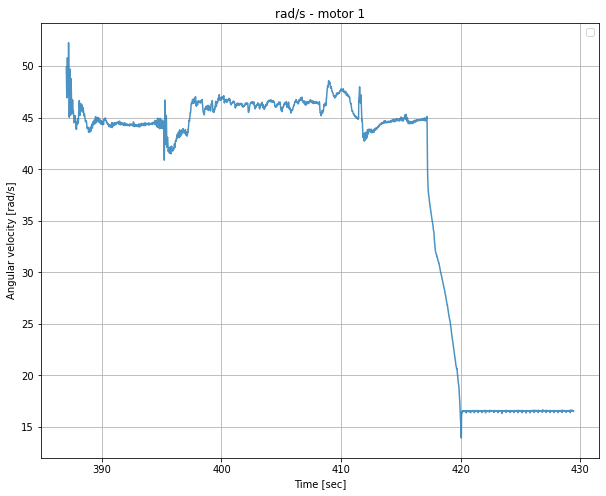

In [147]:
plt.figure(figsize=(10, 8))
plt.title('rad/s - motor 1')
plot_time_vel(df = df_rotor1, lab_str = None)
plt.show()

In [148]:
df_rotor0['cp'] = cp_coefficient(
    rad_s_input = df_rotor0['rad_s'],
    rad_s_data = df_prop['rad_per_sec'],
    cp_data = df_prop['CP'])

df_rotor0['rev_per_sec'] = df_rotor0['rad_s']/(2*np.pi)

display(df_rotor0.head())
display(df_rotor0.tail())


,time,rad_s,cp,rev_per_sec
1,387.036,49.8978,0.0431,7.941482
2,387.040,49.6979,0.0431,7.909666
3,387.044,49.3883,0.0431,7.860392
4,387.048,49.1245,0.0431,7.818407
5,387.052,48.7419,0.0431,7.757514


,time,rad_s,cp,rev_per_sec
10595,429.412,16.5188,0.0431,2.629049
10596,429.416,16.5185,0.0431,2.629001
10597,429.420,16.5182,0.0431,2.628953
10598,429.424,16.5349,0.0431,2.631611
10599,429.428,16.5470,0.0431,2.633537


In [150]:
power = power_propeller_w(
    cp = df_rotor0['cp'],
    rev_per_sec = df_rotor0['rev_per_sec'],
    propeller_diameter_m = prop_diameter)

df_rotor0['power_w'] = power
df_rotor0['new_time'] = df_rotor0['time'] - list(df_rotor0['time'])[0]
df_rotor0['dP'] = 0.004 * df_rotor0['power_w']
display(df_rotor0.head())

print(f'Power consumed: {df_rotor0.dP.sum()} watts')

,time,rad_s,cp,rev_per_sec,power_w,new_time,dP
1,387.036,49.8978,0.0431,7.941482,2795.674021,0.000,11.182696
2,387.040,49.6979,0.0431,7.909666,2762.208456,0.004,11.048834
3,387.044,49.3883,0.0431,7.860392,2710.906691,0.008,10.843627
4,387.048,49.1245,0.0431,7.818407,2667.698632,0.012,10.670795
5,387.052,48.7419,0.0431,7.757514,2605.851722,0.016,10.423407


Power consumed: 66134.93646503892 watts
